# Exploring Data Analysis for RNA-Sequencing. 

<span style="font-size: 18px;">
    <b>Author </b>- Sanmati Dugad <br> 
    <b>Data </b> - Johns Hopkins - https://github.com/schatzlab/appliedgenomics2022/tree/main/assignments/assignment5 <br>
    <b>Programming Language </b> - Python 3.9.7 <br>

In [1]:
# !pip install --upgrade pip
# !pip install plotly

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns
import umap

from scipy.cluster.vq import kmeans, vq
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import poisson    # Poisson distribution
from scipy.stats import ttest_ind # paired t-test for independent samples
from scipy.stats import ttest_rel # paired t-test for related samples


from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

2024-03-11 04:05:30.222589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 04:05:30.438741: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 04:05:31.191729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-11 04:05:31.191836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Question 1 - Time series

<span style="font-size: 16px;">
The <b> "Expression.txt"</b> file contains normalized expression values for 100 genes over 10 time points. Most genes have a stable background expression level, but some special genes show increased expression over the timecourse and some show decreased expression.

### <b> Question 1a.</b> 
Cluster the genes using an algorithm of your choice. Which genes show increasing expression and which genes show decreasing expression, and how did you determine this? What is the background expression level (numerical value) and how did you determine this?

In [30]:
# Set working directory
os.chdir("/home/data/Git_RNA-Seq-Data-Analysis/Assignment5/")

# Read data
Expression_Data = pd.read_csv("Expression.txt", header=0, sep="\t", index_col=0)

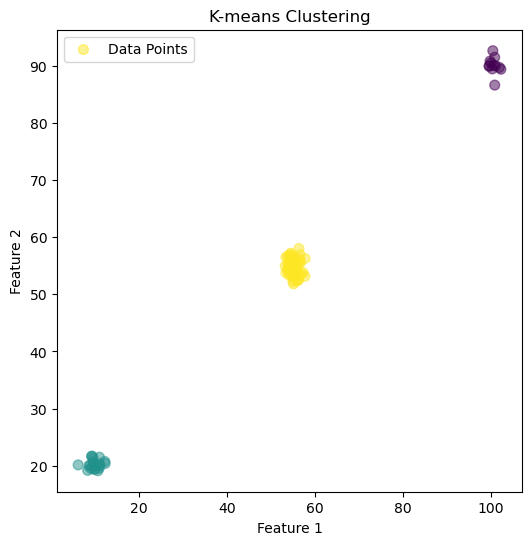

In [31]:
# K-Means clustering
centroids, _ = kmeans(Expression_Data.values, 3)
idx, _ = vq(Expression_Data.values, centroids)

plt.figure(figsize=(6, 6))
plt.scatter(Expression_Data.values[:, 0], Expression_Data.values[:, 1],
            c=idx, cmap='viridis', s=50, alpha=0.5, label = 'Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.legend()
plt.show()

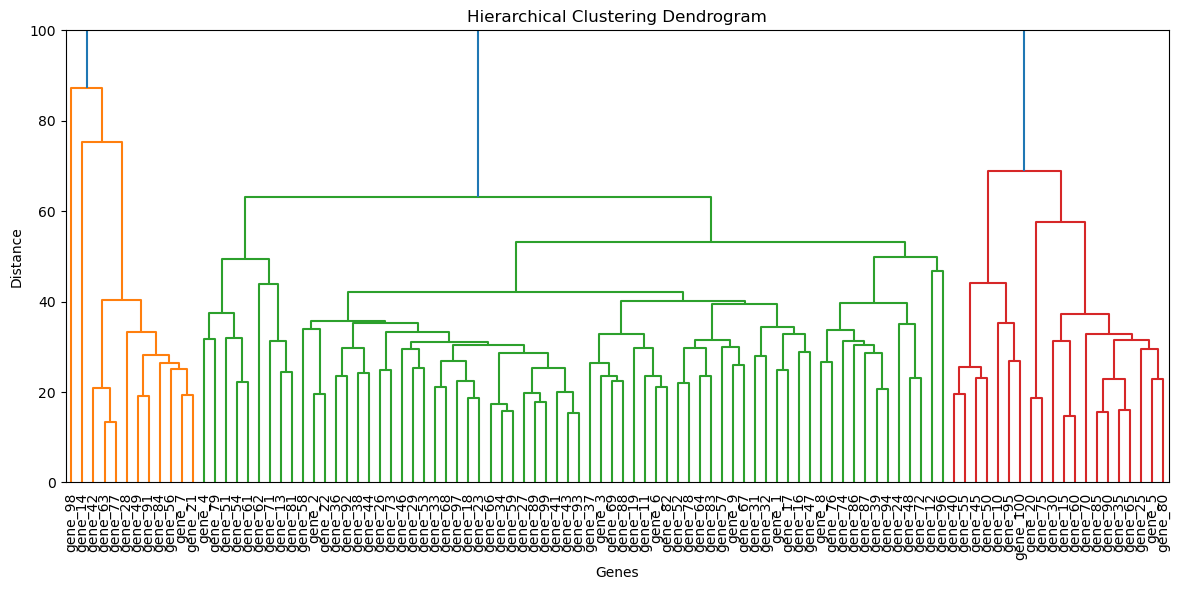

In [32]:
# Hierarchical clustering
distance = np.sum(np.abs(Expression_Data.values[:, None, :] - Expression_Data.values[None, :, :]), axis=2)    #Calculating Manhattan Pairwise distance
clusters = linkage(distance, method='average')    #perform hierarchial clustering

plt.figure(figsize=(12, 6))
dendrogram(clusters,labels=Expression_Data.index, leaf_rotation=90, leaf_font_size = 10)
plt.xlabel('Genes')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.tight_layout()  # Adjust layout
plt.ylim(0,100)
plt.show()

In [33]:
# Split data by cluster
background = Expression_Data[idx == 2]
increasing = Expression_Data[idx == 1]
decreasing = Expression_Data[idx == 0]

# Transpose data
background_expres = background.iloc[:, :10]
increasing_expres = increasing.iloc[:, :10]
decreasing_expres = decreasing.iloc[:, :10]

# Initialize lists to store slopes
background_slopes = []
increasing_slopes = []
decreasing_slopes = []


In [34]:
# a = decreasing_expres.values[6]
# b = np.arange(1, 11).reshape(-1,1)
# print(a)
# model = LinearRegression().fit(b,a)
# print(model.coef_)

In [35]:
# Time points
time_point = np.arange(1, 11).reshape(-1,1)

    
# Linear regression for each gene in increasing cluster
for i in range(11):
    x = increasing_expres.values[i]  # Reshape to 2D array
    model = LinearRegression().fit(time_point, x)  # Fit linear regression model
    increasing_slopes.append(model.coef_)  # Append slope coefficient
    

# Linear regression for each gene in background cluster
for i in range(11):
    x = background_expres.values[i]  # Reshape to 2D array
    model = LinearRegression().fit(time_point, x)  # Fit linear regression model
    background_slopes.append(model.coef_)  # Append slope coefficient

# Linear regression for each gene in decreasing cluster
for i in range(11):
    x = decreasing_expres.values[i]  # Reshape to 2D array
    model = LinearRegression().fit(time_point, x)  # Fit linear regression model
    decreasing_slopes.append(model.coef_)  # Append slope coefficient

# Print mean slopes
print("Mean Slope for the Increasing Cluster is: " + str(round(np.mean(increasing_slopes))))  # Mean slope for increasing cluster
print("Mean Slope for the Background Cluster is: " + str(round(np.mean(background_slopes)))) # Mean slope for background cluster
print("Mean Slope for the Decreasing Cluster is: " + str(round(np.mean(decreasing_slopes))) + "\n")  # Mean slope for decreasing cluster

print("The Background Expression Level is: " + str(round((background.mean(axis = 1)).mean(axis=0),3)))    # First calculate rowwise mean, then mean of "Mean column"
#print(model.score(b,a))
#print(model.intercept_)

Mean Slope for the Increasing Cluster is: 10
Mean Slope for the Background Cluster is: 0
Mean Slope for the Decreasing Cluster is: -10

The Background Expression Level is: 55.007


<span style="font-size: 16px;">
    
### <b> Answer 1a </b>
1. There are 12 genes that show decrease in expression over time and 20 genes that show increase in expression over time. <br><br>

2. <b> The genes that show decreasing in expression are: </b><br>
gene_7, gene_14, gene_21, gene_28, gene_42, gene_49, gene_56, gene_63, gene_77, gene_84, gene_91, gene_98 <br><br>

3. <b> The genes that show increasing in expression are: </b><br>
gene_5, gene_10, gene_15, gene_20, gene_25, gene_30, gene_35, gene_40, gene_45, gene_50, gene_55, gene_60, gene_65, gene_70, gene_75, gene_80, gene_85, gene_90, gene_95, gene_100 <br><br>

4. The genes were seperated into clusters using kmeans clustering and also by hierarchial clustering. The increasing and decreasing clusters were then identified using time point regression for each gene in each cluster and then calculating the average slope. <br><br>

5. Here cluster 3 corresponds to the background genes because it has an averaged slope of around -0.011. This cluster consists of 68 genes and the background expression level of these genes "mean(background) = 55.007 " <br><br>

<span style="font-size: 16px;">
    
### <b> Question 1b.</b>
Next, Calculate the first two principal components of the expression matrix. Show the plot and color the points based on their cluster from part (a). Does the PC1 axis, PC2 axis, neither, or both correspond to the clustering?

In [36]:
## Adding clusters as a column to data for futher dimentionality reduction analysis and visualizations.
Expression_Data['clusters'] = idx

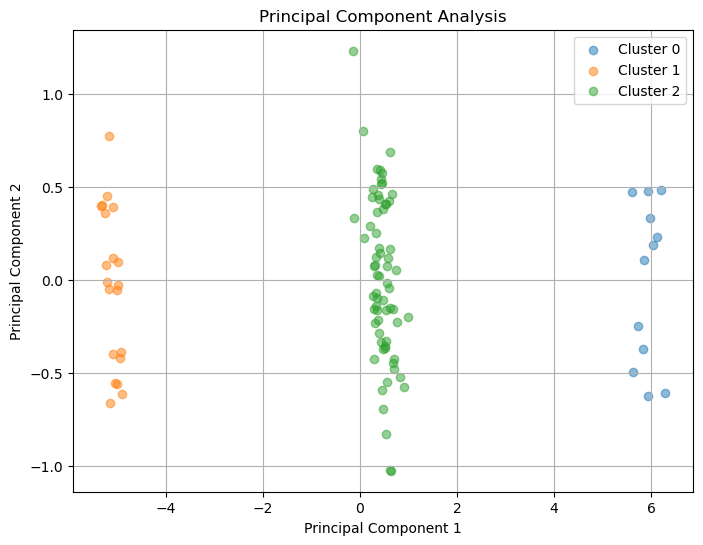

In [37]:
## PCA

X = Expression_Data.iloc[:,:10]
clusters = Expression_Data['clusters']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

unique_clusters = np.unique(clusters)

plt.figure(figsize=(8, 6))
for cluster in unique_clusters:
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], alpha=0.5, label=f'Cluster {cluster}')
plt.title('Principal Component Analysis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

<span style="font-size: 16px;">

### Answer 1b:
Yes both the PC1 and PC2 axis correspond to the clustering results.
The same genes with increasing and decreasing expression were also calculated by
both kmeans and hierarchial clustering. 



<span style="font-size: 16px;">

### Question 1c:
Create a heatmap of the expression matrix. Order the genes by cluster, but keep the time points in numerical order.

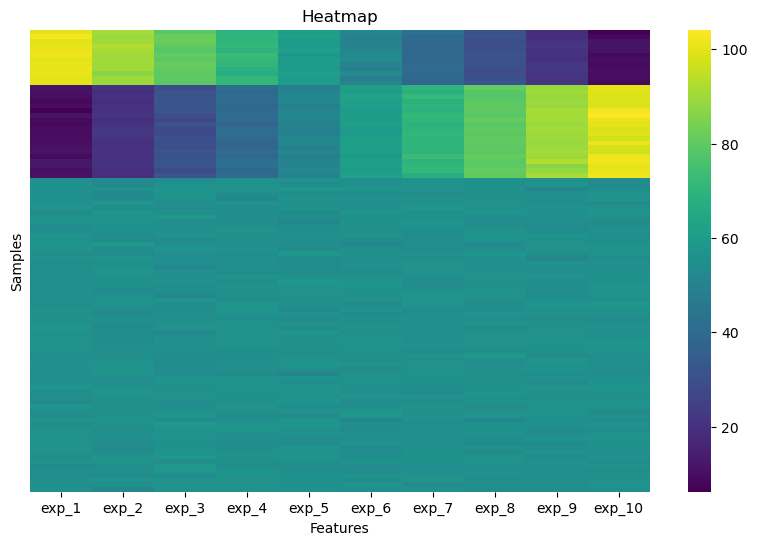

In [38]:
## Heatmap

Expression_Data2 = Expression_Data.sort_values(by='clusters')    # Order data by clusters for better visualization

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(Expression_Data2.iloc[:, :10].values, cmap='viridis', cbar=True,
            xticklabels=Expression_Data2.columns[:10], yticklabels=False)
plt.title('Heatmap')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

<span style="font-size: 16px;">

### Question 1d:
Visualize the expression data using t-SNE.

0.508748471736908


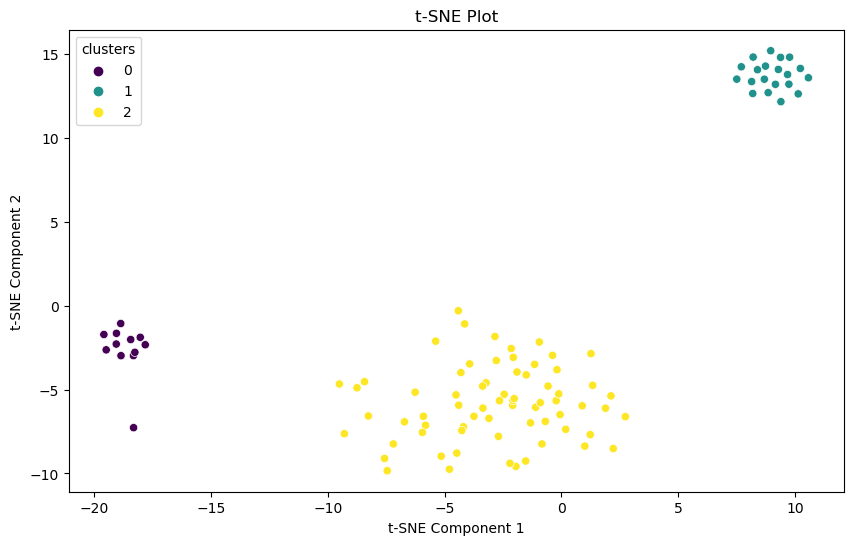

In [39]:
## T-SNE 

# Extract features for t-SNE
X = Expression_Data.iloc[:, :10]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, init='random',
            method = 'barnes_hut', angle = 0.5, n_iter=300)
tsne_result = tsne.fit_transform(X)
print(tsne.kl_divergence_)

# Create DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['X1', 'X2'])
tsne_df.index = Expression_Data.index

# Add cluster information
tsne_df['clusters'] = Expression_Data2['clusters']
tsne_df

# Plot with Seaborn scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='X1', y='X2', hue='clusters', palette='viridis')
plt.title('t-SNE Plot')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

<span style="font-size: 16px;">

### Question 1e:
Using the same data, visualize the expression data using UMAP.

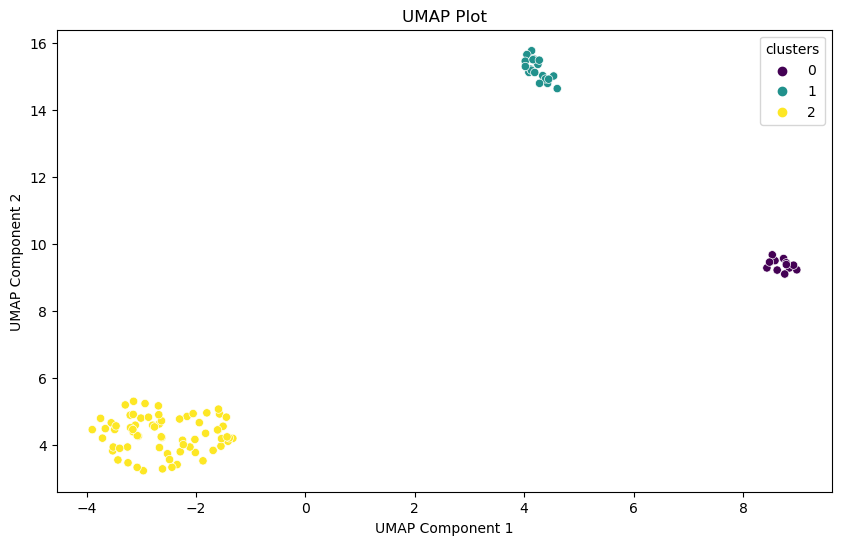

In [40]:
## UMAP

# Extract features for UMAP
X = Expression_Data.iloc[:, :10]

# Perform UMAP dimensionality reduction
umap_result = umap.UMAP(n_components=3, random_state=0, init="random").fit_transform(X)

# Create DataFrame for UMAP results
umap_df = pd.DataFrame(umap_result, columns=['X1', 'X2', 'X3'])
umap_df.index = Expression_Data.index

# Add cluster information from Expression_Data2
umap_df['clusters'] = Expression_Data['clusters']

# Plot with Seaborn scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='X1', y='X2', hue='clusters', palette='viridis')
plt.title('UMAP Plot')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

<span style="font-size: 16px;">

### Question 1f:
In a few sentences, compare the (1) heatmap, (2) PCA, (3) t-SNE and (4) UMAP results. Be sure to comment on understandability, relative positioning of clusters, runtime, and any other significant factors that you see.

<span style="font-size: 16px;">

### Answer 1f:  
<b> Heatmap: </b> It clearly bifurcates the increasing expression of genes over time (for the 20 genes)
    and decreasing expression of genes  over time ( for the 12 genes).
    i.e heat map bifurcates the three clusters along Y-axis and shows the steady increase and decrease
    over time of the respective gene expression along X-axis. 
    This is the only method that clusters both the rows and columns and is able to present
    it on a single graph.

<b>PCA: </b> It divides the genes into three parts.
    Genes with an overall increase in expression are on the positive X-axis and
    the gene with an overall decrease in gene expression are on the negative X-axis.
    Like the heatmap, PCA does not show an increase in expression of each gene over time.
    PCA and clustering give the same results. The data points though bifurcated are all cluttered together.

<b>t-SNE: </b>This method uses probability theory. 
    Compared to the PCA method, it takes significantly more time to converge,
    but presents significantly better insights when visualized
    (Like PCA the data points are not cluttered. They are bifurcated and clear).
    Here I project the gene expression data to two dimensions. 
    tSNE result gives one false-positive value 
    (i.e one low expressed gene as predicted by kmeans is cluttered with the normal values.) 
    This method is less accurate than UMAP.

<b>UMAP: </b> This method is also used to visualize complex data into low dimensions.
    As the number of datapoints increase, UMAP becomes more time efficient as compared to the tSNE. 
    This method did not give false positive value like the tSNE.
    Overall, I found UMAP to be the most convenient tool.
    It was faster than all the methods and gave a clear bifurcation between clusters.


<span style="font-size: 16px;">

## Question 2 - Sampling Simulation

A typical human cell has ~250,000 transcripts, and a typical bulk RNA-seq experiment may involve millions of cells. Consequently, in an RNAseq experiment you may start with trillions of RNA molecules, although your sequencer will only give a few tens of millions of reads. Therefore your RNAseq experiment will be a small sampling of the full composition. We hope the sequences will be a representative sample of the total population, but if your sample is very unlucky or biased it may not represent the true distribution. We will explore this concept by sampling a small subset of transcripts (500 to 50000) out of a much larger set (1M) so that you can evaluate this bias.

In <b> data1.txt </b> with 100,000 lines we provide an abstraction of RNA-seq data where normalization has been performed and the number of times a gene name occurs corresponds to the number of transcripts in the sample.

### Question 2a. 
Randomly sample 500 rows. Do this simulation 10 times and record the relative abundance of each of the 15 genes. Make a scatterplot the mean vs. variance of each gene (x-axis=mean of gene_i, y-axis=variance of gene_i)

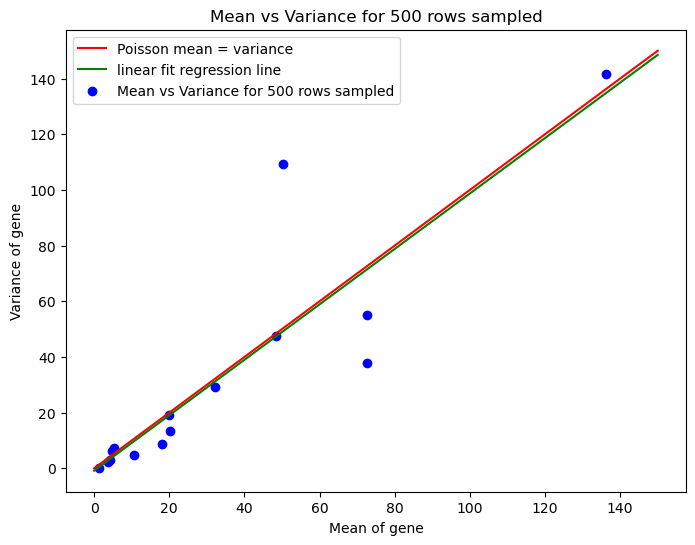

,1,2,3,4,5,6,7,8,9,10,mean,variance,abundance
1,NaN,NaN,2.0,NaN,NaN,1.0,1.0,2.0,1.0,1.0,1.333333,0.266667,0.0016
2,5.0,5.0,5.0,1.0,3.0,4.0,5.0,7.0,5.0,2.0,4.200000,3.066667,0.0084
3,3.0,2.0,8.0,8.0,2.0,5.0,4.0,5.0,9.0,8.0,5.400000,7.155556,0.0108
4,3.0,7.0,2.0,3.0,5.0,5.0,4.0,2.0,4.0,3.0,3.800000,2.400000,0.0076
5,4.0,10.0,3.0,2.0,6.0,4.0,4.0,5.0,3.0,8.0,4.900000,6.100000,0.0098
6,7.0,9.0,9.0,13.0,13.0,8.0,10.0,11.0,13.0,12.0,10.500000,4.944444,0.0210
7,21.0,20.0,19.0,15.0,21.0,12.0,19.0,19.0,16.0,20.0,18.200000,8.622222,0.0364
8,24.0,13.0,22.0,20.0,26.0,13.0,22.0,20.0,17.0,22.0,19.900000,18.988889,0.0398
9,22.0,19.0,15.0,22.0,19.0,23.0,23.0,13.0,22.0,24.0,20.200000,13.511111,0.0404
10,34.0,23.0,32.0,34.0,27.0,30.0,32.0,32.0,33.0,44.0,32.100000,29.211111,0.0642


In [42]:
# Load data
data0 = pd.read_csv("data1.txt", header=None)
data1 = data0[0]

# Sampling and table generation for each sample
samples = []
for _ in range(10):
    sample = data1.sample(n=500, replace=False)
    count = sample.value_counts()
    samples.append(count)

# Create DataFrame for samples and transpose it. 
samples_df = pd.DataFrame(samples).transpose()
samples_df.value_counts
samples_df.columns = range(1,11)

def calculate_row_statistics(row):
    mean = row.mean()
    variance = row.var()
    total_sum = row.sum()
    abundance = row.sum() / samples_df.sum().sum()  # Normalize by the total sum of counts
    return pd.Series({'mean': mean, 'variance': variance, 'abundance': abundance})

statistics_df = samples_df.apply(calculate_row_statistics, axis=1)

# Create DataFrame
# Q2_1 = pd.DataFrame(mean_var_abundance)
Q2_1 = pd.concat([samples_df, statistics_df], axis=1)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(Q2_1['mean'], Q2_1['variance'], color='blue', label='Mean vs Variance for 500 rows sampled')
plt.plot(np.arange(151), np.arange(151), color='red', label='Poisson mean = variance')
lr = LinearRegression().fit(Q2_1[['mean']], Q2_1['variance'])
plt.plot(np.arange(151), lr.predict(np.arange(151).reshape(-1, 1)), color='green', label='linear fit regression line')
plt.xlabel('Mean of gene')
plt.ylabel('Variance of gene')
plt.title('Mean vs Variance for 500 rows sampled')
plt.legend()
plt.show()

Q2_1

<span style="font-size: 16px;">

### Question 2b. 
Do the same sampling experiment but sample 5000 rows each time. Again plot the mean vs. variance.

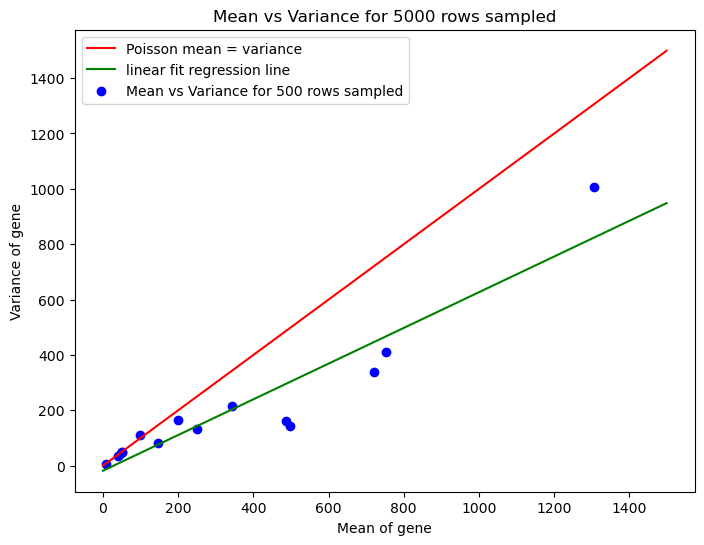

,0,0,0,0,0,0,0,0,0,0,mean,variance,abundance
1,8,9,6,12,8,9,11,5,9,14,9.1,7.211111,0.00182
2,50,44,47,34,32,43,39,37,34,39,39.9,35.655556,0.00798
3,51,44,58,42,47,59,53,61,45,45,50.5,48.055556,0.01010
4,48,45,44,42,41,62,43,55,48,53,48.1,44.988889,0.00962
5,48,58,59,62,45,43,45,45,46,53,50.4,48.933333,0.01008
6,97,94,100,109,100,95,119,88,99,81,98.2,109.511111,0.01964
7,155,155,137,144,147,154,132,136,157,145,146.2,81.066667,0.02924
8,181,199,190,222,196,196,193,217,209,190,199.3,165.788889,0.03986
9,257,231,252,254,270,246,254,232,246,253,249.5,134.277778,0.04990
10,344,347,335,376,332,319,348,347,348,342,343.8,214.177778,0.06876


In [46]:
# Load data
data0 = pd.read_csv("data1.txt", header=None)
data1 = data0[0]

# Sampling and table generation for each sample
samples = []
for _ in range(10):
    sample = data1.sample(n=5000, replace=False)
    count = sample.value_counts()
    samples.append(count)

# Create DataFrame for samples and transpose it. 
samples_df = pd.DataFrame(samples).transpose()
samples_df.value_counts

#samples_df['Mean'] = samples_df.mean(axis = 1)
#samples_df[]


def calculate_row_statistics(row):
    mean = row.mean()
    variance = row.var()
    total_sum = row.sum()
    abundance = row.sum() / samples_df.sum().sum()  # Normalize by the total sum of counts
    return pd.Series({'mean': mean, 'variance': variance, 'abundance': abundance})

statistics_df = samples_df.apply(calculate_row_statistics, axis=1)

# Create DataFrame
# Q2_1 = pd.DataFrame(mean_var_abundance)
Q2_1 = pd.concat([samples_df, statistics_df], axis=1)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(Q2_1['mean'], Q2_1['variance'], color='blue', label='Mean vs Variance for 500 rows sampled')
plt.plot(np.arange(1500), np.arange(1500), color='red', label='Poisson mean = variance')
lr = LinearRegression().fit(Q2_1[['mean']], Q2_1['variance'])
plt.plot(np.arange(1500), lr.predict(np.arange(1500).reshape(-1, 1)), color='green', label='linear fit regression line')
plt.xlabel('Mean of gene')
plt.ylabel('Variance of gene')
plt.title('Mean vs Variance for 5000 rows sampled')
plt.legend()
plt.show()

Q2_1

<span style="font-size: 16px;">

### Question 2c. 
Do the same sampling experiment but sample 50000 rows each time. Again plot the mean vs. variance.

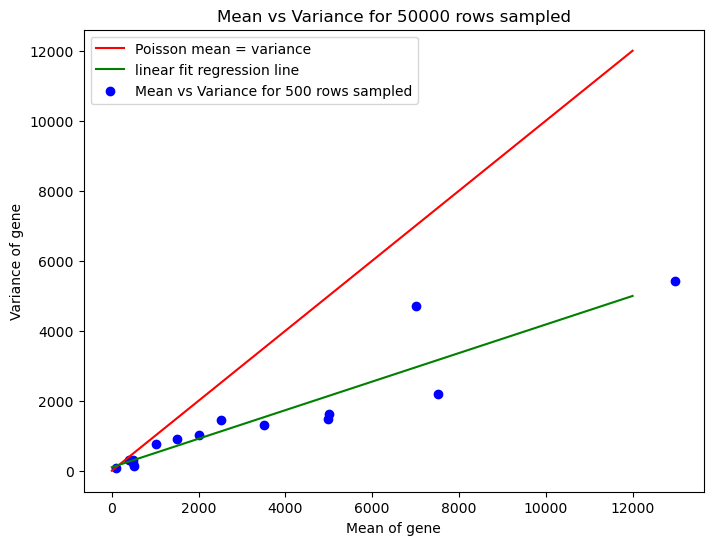

,0,0,0,0,0,0,0,0,0,0,mean,variance,abundance
1,102,97,92,90,117,107,98,109,98,96,100.6,68.488889,0.002012
2,425,383,411,386,388,412,418,378,412,385,399.8,299.511111,0.007996
3,506,497,516,490,464,508,510,501,498,502,499.2,207.066667,0.009984
4,523,505,507,487,490,498,511,499,509,490,501.9,126.988889,0.010038
5,455,513,511,484,502,510,510,492,499,505,498.1,314.322222,0.009962
6,1007,1025,1027,992,1038,1043,997,970,1019,961,1007.9,769.655556,0.020158
7,1501,1504,1473,1458,1517,1483,1533,1517,1456,1542,1498.4,904.488889,0.029968
8,2017,2002,1981,1967,1944,2022,1972,2048,1995,2029,1997.7,1029.344444,0.039954
9,2505,2492,2499,2435,2521,2512,2539,2477,2574,2539,2509.3,1453.566667,0.050186
10,3454,3493,3488,3538,3573,3500,3483,3465,3487,3466,3494.7,1293.344444,0.069894


In [45]:
# Load data
data0 = pd.read_csv("data1.txt", header=None)
data1 = data0[0]

# Sampling and table generation for each sample
samples = []
for _ in range(10):
    sample = data1.sample(n=50000, replace=False)
    count = sample.value_counts()
    samples.append(count)

# Create DataFrame for samples and transpose it. 
samples_df = pd.DataFrame(samples).transpose()
samples_df.value_counts

#samples_df['Mean'] = samples_df.mean(axis = 1)
#samples_df[]


def calculate_row_statistics(row):
    mean = row.mean()
    variance = row.var()
    total_sum = row.sum()
    abundance = row.sum() / samples_df.sum().sum()  # Normalize by the total sum of counts
    return pd.Series({'mean': mean, 'variance': variance, 'abundance': abundance})

statistics_df = samples_df.apply(calculate_row_statistics, axis=1)

# Create DataFrame
# Q2_1 = pd.DataFrame(mean_var_abundance)
Q2_1 = pd.concat([samples_df, statistics_df], axis=1)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(Q2_1['mean'], Q2_1['variance'], color='blue', label='Mean vs Variance for 500 rows sampled')
plt.plot(np.arange(12000), np.arange(12000), color='red', label='Poisson mean = variance')
lr = LinearRegression().fit(Q2_1[['mean']], Q2_1['variance'])
plt.plot(np.arange(12000), lr.predict(np.arange(12000).reshape(-1, 1)), color='green', label='linear fit regression line')
plt.xlabel('Mean of gene')
plt.ylabel('Variance of gene')
plt.title('Mean vs Variance for 50000 rows sampled')
plt.legend()
plt.show()

Q2_1

<span style="font-size: 16px;">
    
### Question 2d. 
Is the variance greater in (a), (b) or (c)? What is the relationship between mean abundance and variance? Why?

<span style="font-size: 16px;">
    
### Answer 2d :
1. Variance is greater in (c). <br> <br>
2. With a small sample size the mean vs ratio points are closet to poisson distribution. But with an increase in sample size the points do not fit into the poisson distribution and heavily deviate.vWith a larger sample size, the distribution tends to follow a normal distribution due to the Central Limit Theorem, and it may deviate from the Poisson distribution. <br> <br>
3. In terms of scatter plot the correlation is positive but the data does't fit into the the distribution. <br><br>
4. While for small sample size, the data overfits; for large sampling the data shows over dispersion. <br><br>
5. Here, Relative Abundance of a gene increases with an increase variance.<br><br>

<span style="font-size: 16px;">

## Question 3. Differential Expression

### Question 3a. 
Using the file from question 2 (data1.txt) along with data2.txt, randomly sample 5000 rows from each file. Sample 3 times for each file (this emulates making experimental replicates) and conduct a paired t-test for differential expression of each of the 15 genes. Which genes are significantly differentially expressed at the 0.05 level and what is their mean fold change?
Ans: A Difference in the mean values of the two files show the following results.

In [47]:
# Read data
data1 = pd.read_csv("data1.txt", header=None)
data2 = pd.read_csv("data2.txt", header=None)

In [48]:
samples = {}
for dataset in [data1, data2]:
    for i in range(3):
        sample = dataset.sample(n=5000, replace=False)
        counts = sample[0].value_counts()
        samples[f'sample{i+1}_{dataset.iloc[0,0]}'] = counts

# Create DataFrame for samples
Q3_1 = pd.DataFrame(samples)

# Calculate mean and log2 fold change
Q3_1['data1_mean'] = Q3_1[['sample1_13', 'sample2_13', 'sample3_13']].mean(axis=1)
Q3_1['data2_mean'] = Q3_1[['sample1_15', 'sample2_15', 'sample3_15']].mean(axis=1)
Q3_1['log2_foldchange'] = np.log2(Q3_1['data2_mean'] / Q3_1['data1_mean'])

# Perform t-test
def t_test_all_genes(row):
    x1 = row[['sample1_13', 'sample2_13', 'sample3_13']]
    x2 = row[['sample1_15', 'sample2_15', 'sample3_15']]
    t_stat, p_value = ttest_rel(x1, x2)
    # t_stat, p_value = ttest_ind(x1, x2)    # ttest_ind is for independent samples
    return p_value

Q3_1['gene_p_values'] = Q3_1.apply(t_test_all_genes, axis=1)

# Add significance and -log10(p-values)
Q3_1['significant'] = Q3_1['gene_p_values'] < 0.05
Q3_1['log_10_negative'] = -np.log10(Q3_1['gene_p_values'])

Q3_1

,sample1_13,sample2_13,sample3_13,sample1_15,sample2_15,sample3_15,data1_mean,data2_mean,log2_foldchange,gene_p_values,significant,log_10_negative
1,10,11,13,6,4,6,11.333333,5.333333,-1.087463,0.026671,True,1.573953
2,53,53,38,30,28,25,48.000000,27.666667,-0.794886,0.031746,True,1.498311
3,47,47,48,75,81,95,47.333333,83.666667,0.821796,0.023001,True,1.638255
4,53,53,38,57,51,39,48.000000,49.000000,0.029747,0.622036,False,0.206185
5,56,42,44,49,54,50,47.333333,51.000000,0.107641,0.580324,False,0.236330
6,100,112,105,104,89,81,105.666667,91.333333,-0.210307,0.258510,False,0.587522
7,146,133,140,159,139,167,139.666667,155.000000,0.150280,0.130992,False,0.882755
8,200,191,218,226,206,191,203.000000,207.666667,0.032790,0.799796,False,0.097021
9,237,256,252,251,248,247,248.333333,248.666667,0.001935,0.965801,False,0.015112
10,321,356,364,341,359,358,347.000000,352.666667,0.023370,0.534727,False,0.271868


<span style="font-size: 16px;">

### Answer 3a.
1. <b> Gene1, Gene2, Gene3, Gene12, Gene15 </b> have a P-value < 0.05. Hence They are significantly expressed. 
2. Their Mean fold change are  <b> 0.026, 0.031, 0.023, 0.008, 0.009 </b> respectively.

<span style="font-size: 16px;">

### Question 3b. 
Make a volano plot of the data from part a: x-axis=log2(fold change of the mean expression of gene_i); y-axis=-log_10(p_value comparing the expression of gene_i). Label all of the genes that show a statistically siginificant change

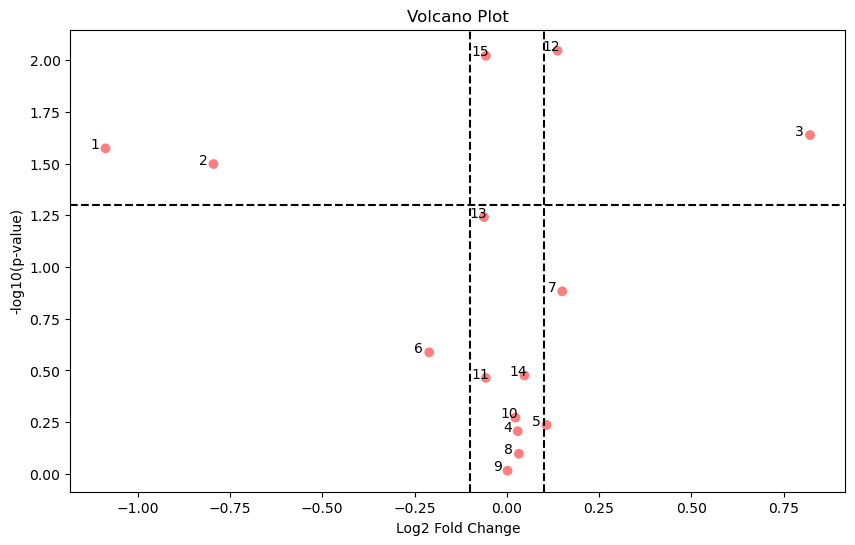

In [51]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(Q3_1['log2_foldchange'], Q3_1['log_10_negative'], color='red', alpha=0.5, 
            edgecolors='none', s=50)
plt.axvline(x=-0.1, color='black', linestyle='--')
plt.axvline(x=0.1, color='black', linestyle='--')
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
for i, txt in enumerate(Q3_1.index):
    plt.text(Q3_1['log2_foldchange'][txt] - 0.04, Q3_1['log_10_negative'][txt], txt, fontsize=10)
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')
plt.show()


<span style="font-size: 16px;">

### Answer 3b. 
In the volcano plot the <b> Gene1, Gene2, Gene3, Gene12, Gene15 </b> show a statistically significant change.

<span style="font-size: 16px;">

### Question 3c
Now sample 5000 rows 10 times from each file, equivalent to making more replicates. Which genes are now significant at the 0.05 level and what is their mean fold change?
Ans:


In [53]:
samples = {}
for dataset in [data1, data2]:
    for i in range(3):
        sample = dataset.sample(n=5000, replace=False)
        counts = sample[0].value_counts()
        samples[f'sample{i+1}_{dataset.iloc[0,0]}'] = counts

# Create DataFrame for samples
Q3_1 = pd.DataFrame(samples)

# Calculate mean and log2 fold change
Q3_1['data1_mean'] = Q3_1[['sample1_13', 'sample2_13', 'sample3_13']].mean(axis=1)
Q3_1['data2_mean'] = Q3_1[['sample1_15', 'sample2_15', 'sample3_15']].mean(axis=1)
Q3_1['log2_foldchange'] = np.log2(Q3_1['data2_mean'] / Q3_1['data1_mean'])

# Perform t-test
def t_test_all_genes(row):
    x1 = row[['sample1_13', 'sample2_13', 'sample3_13']]
    x2 = row[['sample1_15', 'sample2_15', 'sample3_15']]
    t_stat, p_value = ttest_rel(x1, x2)
    # t_stat, p_value = ttest_ind(x1, x2)    # ttest_ind is for independent samples
    return p_value

Q3_1['gene_p_values'] = Q3_1.apply(t_test_all_genes, axis=1)

# Add significance and -log10(p-values)
Q3_1['significant'] = Q3_1['gene_p_values'] < 0.05
Q3_1['log_10_negative'] = -np.log10(Q3_1['gene_p_values'])

Q3_1

,sample1_13,sample2_13,sample3_13,sample1_15,sample2_15,sample3_15,data1_mean,data2_mean,log2_foldchange,gene_p_values,significant,log_10_negative
1,12,10,6,2,7,7,9.333333,5.333333,-0.807355,0.339422,False,0.469260
2,40,27,35,27,31,35,34.000000,31.000000,-0.133267,0.617971,False,0.209032
3,57,37,42,89,89,72,45.333333,83.333333,0.878321,0.032508,True,1.488015
4,55,60,35,46,46,52,50.000000,48.000000,-0.058894,0.854393,False,0.068342
5,47,46,42,61,46,44,45.000000,50.333333,0.161589,0.346803,False,0.459917
6,96,103,102,112,111,91,100.333333,104.666667,0.061001,0.642593,False,0.192064
7,158,131,144,123,142,158,144.333333,141.000000,-0.033709,0.852973,False,0.069065
8,205,212,205,224,239,217,207.333333,226.666667,0.128620,0.046743,True,1.330279
9,241,272,249,263,260,261,254.000000,261.333333,0.041063,0.542856,False,0.265316
10,361,371,362,370,344,360,364.666667,358.000000,-0.026619,0.595278,False,0.225280


<span style="font-size: 16px;">

### Answer 3c:
Here the significantly expressed genes are <b> Gene3, Gene8, Gene15 </b> and their mean fold change are 0.03, 0.04, 0.02 respectively

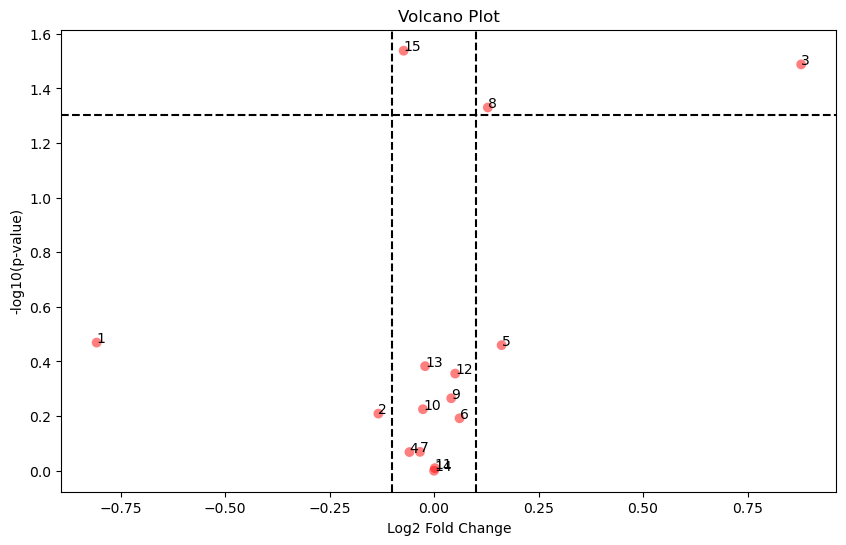

In [56]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(Q3_1['log2_foldchange'], Q3_1['log_10_negative'], color='red', alpha=0.5,
            edgecolors='none', s=50)
plt.axvline(x=-0.1, color='black', linestyle='--')
plt.axvline(x=0.1, color='black', linestyle='--')
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
for i, txt in enumerate(Q3_1.index):
    plt.text(Q3_1['log2_foldchange'][txt], Q3_1['log_10_negative'][txt], txt, fontsize=10)
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')
plt.show()